In [1]:
basedir = '/home/abhinavgupta0110/NeuralODEs_ROM_Closure'

import os

is_google_colab = False
is_use_GPU = False

### Mount the drive

In [2]:
if is_use_GPU:
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('No GPU found!')
    else:
        print(gpu_info)

if is_google_colab:
    from google.colab import drive
    drive.mount('/content/drive')

    %pip install quadpy
    
os.chdir(os.path.join(basedir, 'neuralClosureModels'))

### Load modules

In [3]:
from src.utilities.DDE_Solver import ddeinttf 
from src.utilities.helper_classes import * 
import src.solvers.neuralDDE_with_adjoint_accel as ndde
import src.advec_diff_case.advec_diff_eqn_modcall as adeq
from src.advec_diff_case.ROM_AD_Eqn_Helper_Classes import * 
import src.advec_diff_case.rom_advec_diff_modcall as rom

from IPython.core.debugger import set_trace

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

tf.keras.backend.set_floatx('float32')

## Define some useful classes

In [33]:
### Define a custom plotting function
class custom_plot:

    def __init__(self, x, t):
        self.t = t
        self.X, self.T = np.meshgrid(x.numpy(), t.numpy())
        self.x = x
            
    def plot(self, u, title='Hello', t_max = None):
        fig = plt.figure(figsize=(7, 4.5), facecolor='white')
        ax_u_lowres = fig.add_subplot(111)
        
        ax_u_lowres.cla()
        ax_u_lowres.set_title(title, fontsize=14)
        ax_u_lowres.set_xlabel('x', fontsize=14)
        ax_u_lowres.set_ylabel('t', fontsize=14)
        plot = ax_u_lowres.contourf(self.X, self.T, u, cmap=cm.coolwarm,
                           antialiased=False, levels=np.linspace(-0.3, 0.5, 50), extend='min')
        ax_u_lowres.set_xlim(self.x[0], self.x[-1])
        if t_max == None:
            ax_u_lowres.set_ylim(self.t[0], self.t[-1])
        else:
            ax_u_lowres.set_ylim(self.t[0], t_max)
        plt.colorbar(plot, ax=ax_u_lowres, shrink=0.5, aspect=10)
        
        plt.show

### Initial conditions

In [5]:
class initial_cond:

    def __init__(self, x, app):
        self.x = x
        self.app = app

    def __call__(self, t):
        u0 = self.x / (1. + np.sqrt(1./self.app.t0) * np.exp(self.app.Re * self.x**2 / 4., dtype = np.float64))
        return tf.convert_to_tensor([u0], dtype=tf.float32)

In [6]:
class create_mean_modes:
    def __init__(self, fom_sol, app, t):
        self.fom_sol = fom_sol
        self.app = app
        self.t = t

    def __call__(self):

        u_analy = tf.transpose(self.fom_sol)

        u_mean = tf.expand_dims(tf.reduce_mean(u_analy, axis=-1), axis=1)

        S, U, V = tf.linalg.svd(u_analy - tf.tile(u_mean, [1, len(self.t)]))

        ui = U[:, 0:self.app.rom_dims]

        return u_mean, ui, S

In [7]:
class red_initial_cond:
    
    def __init__(self, ai_t0, u_mean, u_modes):
        self.ai_t0 = ai_t0
        self.u_mean = u_mean
        self.u_modes = u_modes
        
    def __call__(self, t):

        u0_rom = tf.transpose(self.u_mean, perm=[1, 0]) \
            + tf.cast(tf.einsum('ab, db -> da', tf.cast(self.u_modes, tf.float64), tf.cast(self.ai_t0(t), tf.float64)), tf.float32)
        
        return u0_rom

## Main part starts here

### User-defined parameters, create objects, and solve the full order model

In [8]:
app = rom.rom_eqn_args(T = 4.0, nt = 400, L = 1., nx = 100, Re = 1000, u_bc_0 = 0., u_bc_L =0., rom_dims = 3, rom_batch_size = 1, ad_eq_batch_size = 1)

x = tf.linspace(0., app.L, app.nx)
t = tf.linspace(0., app.T, app.nt) # Time array

u0 = initial_cond(x, app) # Initial conditions

op = adeq.operators(app)

u_fom = ddeinttf(adeq.ad_eqn(op, app), u0, t)

print('FOM done!')

FOM done!


### Solve th ROM model and plot

In [9]:
u_mean, ui, sing_val = create_mean_modes(tf.squeeze(u_fom, axis=1), app, t)()

ai_t0 = rom.initial_cond_rom(u0, ui, u_mean)

ai = ddeinttf(rom.rom_ad_eqn(um = u_mean, ui = ui, op = op, app = app), ai_t0, t)

u_rom = tf.tile(tf.expand_dims(tf.transpose(u_mean, perm=[1, 0]), axis=0), [app.nt, app.rom_batch_size, 1]) \
            + tf.cast(tf.einsum('ab, cdb -> cda', tf.cast(ui, tf.float64), tf.cast(ai, tf.float64)), tf.float32)

print('ROM done!')

ROM done!


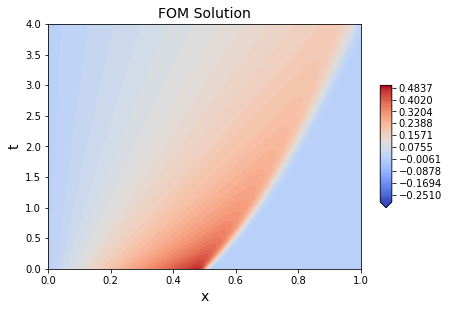

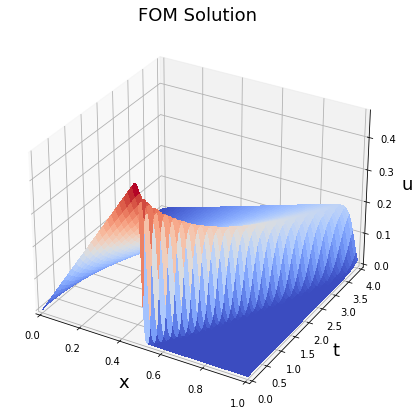

In [50]:
cp = custom_plot(x, t)

cp.plot(tf.squeeze(u_fom, axis=1).numpy(), 'FOM Solution')

fig = plt.figure(figsize=(10, 7), facecolor='white')
ax_u_analy = fig.add_subplot(111, projection='3d')

X, T = np.meshgrid(x.numpy(), t.numpy())

ax_u_analy.cla()
ax_u_analy.set_title('FOM Solution', fontsize=18)
ax_u_analy.set_zlabel('u', fontsize=18)
ax_u_analy.set_xlabel('x', fontsize=18)
ax_u_analy.set_ylabel('t', fontsize=18)
plot = ax_u_analy.plot_surface(X, T, tf.squeeze(u_fom, axis=1).numpy(), cmap=cm.coolwarm,
                    linewidth=0, antialiased=False)
ax_u_analy.set_xlim(x[0], x[-1])
ax_u_analy.set_ylim(t[0], t[-1])

# plt.colorbar(plot, ax=ax_u_analy, shrink=0.5, aspect=10)

fig.show()

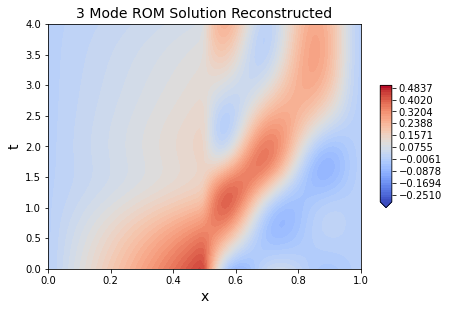

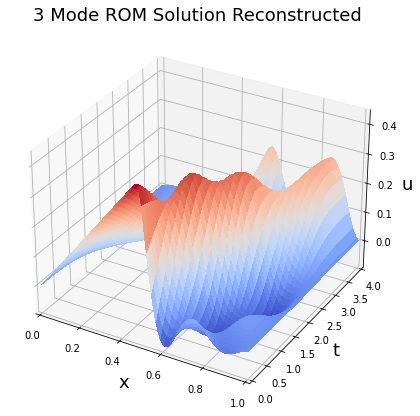

In [51]:
cp = custom_plot(x, t)

cp.plot(tf.squeeze(u_rom, axis=1).numpy(), '3 Mode ROM Solution Reconstructed')

fig = plt.figure(figsize=(10, 7), facecolor='white')
ax_u = fig.add_subplot(111, projection='3d')

X, T = np.meshgrid(x.numpy(), t.numpy())

ax_u.cla()
ax_u.set_title('3 Mode ROM Solution Reconstructed', fontsize=18)
ax_u.set_zlabel('u', fontsize=18)
ax_u.set_xlabel('x', fontsize=18)
ax_u.set_ylabel('t', fontsize=18)
ax_u.plot_surface(X, T, tf.squeeze(u_rom, axis=1).numpy(), cmap=cm.coolwarm,
                    linewidth=0, antialiased=False)
ax_u.set_xlim(x[0], x[-1])
ax_u.set_ylim(t[0], t[-1])

fig.show()

In [12]:
true_ai = u_fom - tf.tile(tf.expand_dims(tf.transpose(u_mean, perm=[1, 0]), axis=0), [app.nt, app.multi_solve_size, 1])
true_ai = tf.cast(tf.einsum('ab, cda -> cdb', tf.cast(ui, tf.float64), tf.cast(true_ai, tf.float64)), tf.float32)

In [13]:
u0_rom = red_initial_cond(ai_t0, u_mean, ui)

u_fom_red_ic = ddeinttf(adeq.ad_eqn(op, app), u0_rom, t)

true_ai_red = u_fom_red_ic - tf.tile(tf.expand_dims(tf.transpose(u_mean, perm=[1, 0]), axis=0), [app.nt, app.multi_solve_size, 1])
true_ai_red = tf.cast(tf.einsum('ab, cda -> cdb', tf.cast(ui, tf.float64), tf.cast(true_ai_red, tf.float64)), tf.float32)

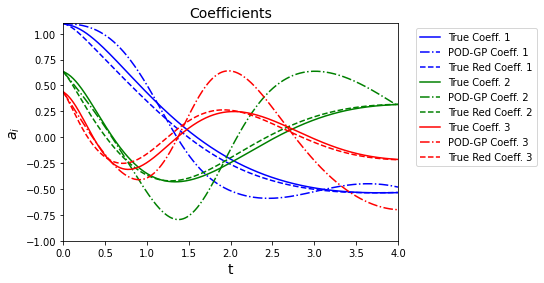

In [44]:
diff_colors = ['b', 'g', 'r', 'k', 'c', 'm']

fig = plt.figure(figsize=(6, 4), facecolor='white')
ax = fig.add_subplot(111)

ax.cla()
ax.set_title('Coefficients', fontsize=14)
ax.set_xlabel('t', fontsize=14)
ax.set_ylabel('$a_i$', fontsize=14)
ax.set_xlim(min(t.numpy()), max(t.numpy()))
ax.set_ylim(-1, 1.1)

for i in range(app.rom_dims):
    ax.plot(t.numpy(), true_ai[:, 0, i], diff_colors[i % app.rom_dims]+'-', label = 'True Coeff. '+str(i+1))
    ax.plot(t.numpy(), ai[:, 0, i], diff_colors[i % app.rom_dims]+'-.', label = 'POD-GP Coeff. '+str(i+1))
    ax.plot(t.numpy(), true_ai_red[:, 0, i], diff_colors[i % app.rom_dims]+'--', label = 'True Red Coeff. '+str(i+1))

ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show() 

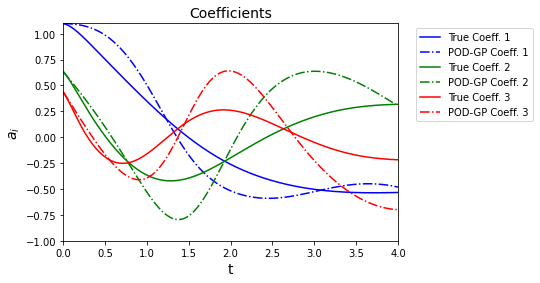

In [15]:
diff_colors = ['b', 'g', 'r', 'k', 'c', 'm']

fig = plt.figure(figsize=(6, 4), facecolor='white')
ax = fig.add_subplot(111)

ax.cla()
ax.set_title('Coefficients', fontsize=14)
ax.set_xlabel('t', fontsize=14)
ax.set_ylabel('$a_i$', fontsize=14)
ax.set_xlim(min(t.numpy()), max(t.numpy()))
ax.set_ylim(-1, 1.1)

for i in range(app.rom_dims):
    ax.plot(t.numpy(), true_ai_red[:, 0, i], diff_colors[i % app.rom_dims]+'-', label = 'True Coeff. '+str(i+1))
    ax.plot(t.numpy(), ai[:, 0, i], diff_colors[i % app.rom_dims]+'-.', label = 'POD-GP Coeff. '+str(i+1))

ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show() 

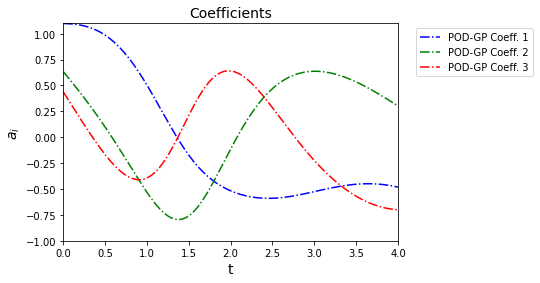

In [45]:
diff_colors = ['b', 'g', 'r', 'k', 'c', 'm']

fig = plt.figure(figsize=(6, 4), facecolor='white')
ax = fig.add_subplot(111)

ax.cla()
ax.set_title('Coefficients', fontsize=14)
ax.set_xlabel('t', fontsize=14)
ax.set_ylabel('$a_i$', fontsize=14)
ax.set_xlim(min(t.numpy()), max(t.numpy()))
ax.set_ylim(-1, 1.1)

for i in range(app.rom_dims):
    ax.plot(t.numpy(), ai[:, 0, i], diff_colors[i % app.rom_dims]+'-.', label = 'POD-GP Coeff. '+str(i+1))

ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show() 

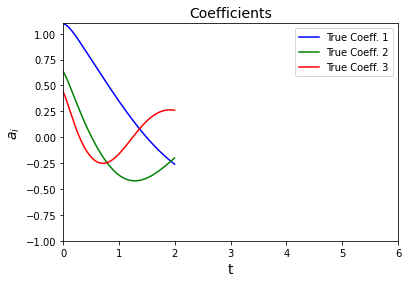

In [54]:
diff_colors = ['b', 'g', 'r', 'k', 'c', 'm']

fig = plt.figure(figsize=(6, 4), facecolor='white')
ax = fig.add_subplot(111)

ax.cla()
ax.set_title('Coefficients', fontsize=14)
ax.set_xlabel('t', fontsize=14)
ax.set_ylabel('$a_i$', fontsize=14)
ax.set_xlim(min(t.numpy()), max(t.numpy()))
ax.set_ylim(-1, 1.1)

for i in range(app.rom_dims):
    ax.plot(t.numpy()[0:int(len(t.numpy())/2)], true_ai_red[0:int(len(t.numpy())/2), 0, i], diff_colors[i % app.rom_dims]+'-', label = 'True Coeff. '+str(i+1))

ax.set_xlim(0, 6.0)
ax.legend(loc="upper right")
plt.show() 

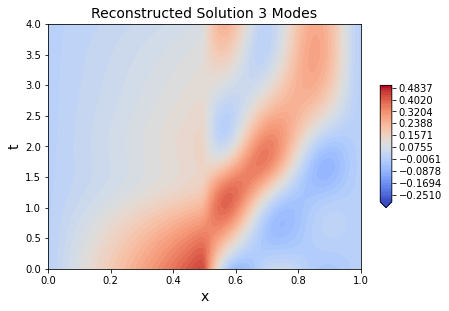

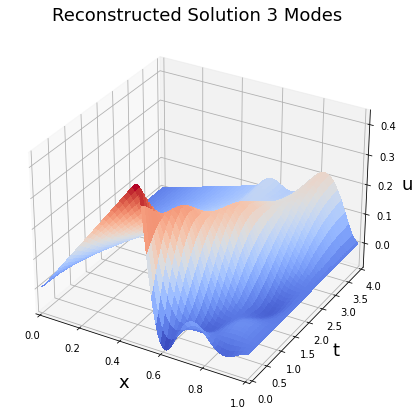

In [52]:
u_rom_red = tf.tile(tf.expand_dims(tf.transpose(u_mean, perm=[1, 0]), axis=0), [app.nt, app.rom_batch_size, 1]) \
            + tf.cast(tf.einsum('ab, cdb -> cda', tf.cast(ui, tf.float64), tf.cast(true_ai_red, tf.float64)), tf.float32)

cp = custom_plot(x, t)

cp.plot(tf.squeeze(u_rom, axis=1).numpy(), 'Reconstructed Solution 3 Modes')

fig = plt.figure(figsize=(10, 7), facecolor='white')
ax_u = fig.add_subplot(111, projection='3d')

X, T = np.meshgrid(x.numpy(), t.numpy())

ax_u.cla()
ax_u.set_title('Reconstructed Solution 3 Modes', fontsize=18)
ax_u.set_xlabel('x', fontsize=18)
ax_u.set_ylabel('t', fontsize=18)
ax_u.set_zlabel('u', fontsize=18)
ax_u.plot_surface(X, T, tf.squeeze(u_rom_red, axis=1).numpy(), cmap=cm.coolwarm,
                    linewidth=0, antialiased=False)
ax_u.set_xlim(x[0], x[-1])
ax_u.set_ylim(t[0], t[-1])

fig.show()

In [19]:
sing_val_cumsum = np.cumsum(sing_val.numpy())/np.cumsum(sing_val.numpy())[-1]

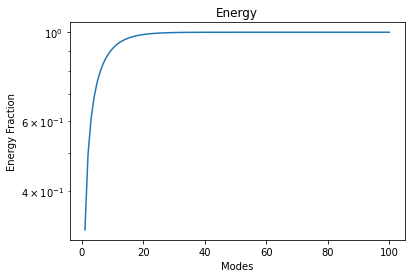

In [20]:
fig = plt.figure(figsize=(6, 4), facecolor='white')
ax = fig.add_subplot(111)

ax.cla()
ax.set_title('Energy')
ax.set_xlabel('Modes')
ax.set_ylabel('Energy Fraction')

ax.semilogy(np.linspace(1, len(sing_val_cumsum), len(sing_val_cumsum)), sing_val_cumsum)

plt.show() 

In [21]:
sing_val_cumsum

array([0.32016855, 0.49480894, 0.6082759 , 0.68998545, 0.75143594,
       0.79913634, 0.8367612 , 0.86682546, 0.8910283 , 0.91063094,
       0.92657506, 0.93958294, 0.9502265 , 0.958949  , 0.9661148 ,
       0.97200644, 0.97686166, 0.9808644 , 0.9841719 , 0.98690546,
       0.9891699 , 0.9910451 , 0.99260145, 0.9938921 , 0.99496394,
       0.9958529 , 0.9965906 , 0.99720156, 0.99770766, 0.9981258 ,
       0.9984712 , 0.9987557 , 0.99898976, 0.9991816 , 0.9993385 ,
       0.99946594, 0.99956924, 0.9996588 , 0.99974144, 0.99980694,
       0.99985826, 0.99989796, 0.999928  , 0.99995035, 0.9999664 ,
       0.9999776 , 0.9999851 , 0.99999094, 0.9999955 , 0.9999981 ,
       0.9999992 , 0.99999964, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [22]:
sing_val.numpy()

array([1.08930826e+01, 5.94178391e+00, 3.86048079e+00, 2.77999997e+00,
       2.09072757e+00, 1.62291002e+00, 1.28010905e+00, 1.02287543e+00,
       8.23452890e-01, 6.66940629e-01, 5.42465985e-01, 4.42567736e-01,
       3.62124264e-01, 2.96769887e-01, 2.43802220e-01, 2.00451732e-01,
       1.65189683e-01, 1.36184797e-01, 1.12534836e-01, 9.30023566e-02,
       7.70398825e-02, 6.38019964e-02, 5.29510304e-02, 4.39095721e-02,
       3.64691056e-02, 3.02419681e-02, 2.51000430e-02, 2.07861159e-02,
       1.72193609e-02, 1.42264711e-02, 1.17526632e-02, 9.67843737e-03,
       7.96458405e-03, 6.52723154e-03, 5.33816405e-03, 4.33831196e-03,
       3.51180159e-03, 3.04687885e-03, 2.80997506e-03, 2.22930172e-03,
       1.74735289e-03, 1.34880748e-03, 1.02256262e-03, 7.58373586e-04,
       5.47321804e-04, 3.81516613e-04, 2.53849110e-04, 1.98942667e-04,
       1.57614355e-04, 8.79961735e-05, 3.78444274e-05, 1.64187240e-05,
       9.81763242e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [23]:
np.where(sing_val.numpy() < np.finfo(np.float32).eps * 100000.)[0][0]

30

In [24]:
np.finfo(np.float32).eps * 10000.

0.0011920928955078125